In [14]:
import os
import warnings

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, train_test_split
import plotly.express as px
import plotly.graph_objects as go
warnings.simplefilter("ignore")

# 環境設定

In [2]:
# 共通設定
DATA_PATH = "../data"

# 関数定義

In [3]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """データの前処理."""
    # 金額をobj->int型へ変換
    dollar_amount_cols = ["DisbursementGross", "GrAppv", "SBA_Appv"]
    for col in dollar_amount_cols:
        df[col] = df[col].apply(lambda x: x.replace("$", "").replace(".", "").replace(",", "")).astype(int).copy()
    # 年月関連を年と月で分ける
    ymd_cols = ["DisbursementDate", "ApprovalDate"]
    for col in ymd_cols:
        df[col + "_year"] = pd.to_datetime(df[col]).apply(lambda x: x.year)
        df[col + "_month"] = pd.to_datetime(df[col]).apply(lambda x: x.month)
        df = df.drop(columns=col)
    # category型への変換
    obj_cols = df.select_dtypes(include=object).columns
    df[obj_cols] = df[obj_cols].astype("category").copy()
    return df

In [4]:
def main(params):
    train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), index_col=0)
    test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"), index_col=0)

    # 前処理
    train_data = preprocess_data(train_data)
    test_data = preprocess_data(test_data)

    # 説明変数と目的変数に分ける
    X = train_data.drop(columns="MIS_Status").copy()
    y = train_data["MIS_Status"].copy()
    X_test = test_data.copy()

    # 学習
    X_train_eval, X_valid, y_train_eval, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, test_size=0.25, random_state=42)
    train_dataset = lgb.Dataset(X_train, label=y_train)
    eval_dataset = lgb.Dataset(X_eval, label=y_eval)
    model = lgb.train(
        params,
        train_dataset,
        num_boost_round=1000,
        valid_sets=[train_dataset, eval_dataset],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)],
    )
    y_pred_proba = model.predict(X_valid)
    return y_valid, y_pred_proba

# 分析

In [11]:
params_false = {
    "objective": "binary",
    "metric": "binary_logloss",
    "is_unbalance": False,
}
params_true =  {
    "objective": "binary",
    "metric": "binary_logloss",
    "is_unbalance": True,
}

In [12]:
params_list = [params_false, params_true]
pred_probas = []
for params in params_list:
    y, y_pred_proba = main(params)
    pred_probas.append(y_pred_proba)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 22668, number of negative: 2715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25383, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.893039 -> initscore=2.122162
[LightGBM] [Info] Start training from score 2.122162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.252418	valid_1's binary_logloss: 0.286971
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[L

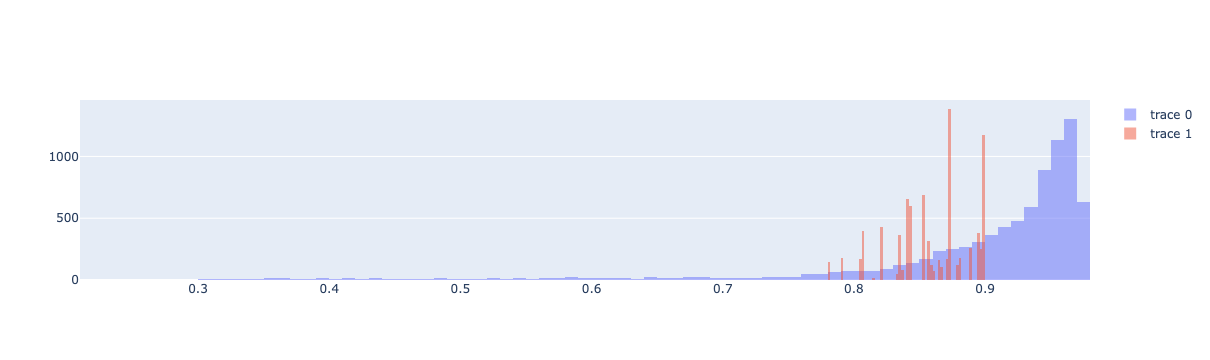

In [18]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=pred_probas[0], nbinsx=80, opacity=0.5, name="False"))
fig.add_trace(go.Histogram(x=pred_probas[1], nbinsx=80, opacity=0.5, name="True"))
fig.update_layout(barmode='overlay')

In [25]:
print(f"is_unbalance=Falseの場合のユニーク数：{np.unique(pred_probas[0]).shape}")
print(f"is_unbalance=Trueの場合のユニーク数：{np.unique(pred_probas[1]).shape}")

is_unbalance=Falseの場合のユニーク数：(7203,)
is_unbalance=Trueの場合のユニーク数：(31,)


In [26]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), index_col=0)
test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"), index_col=0)

# 前処理
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# 説明変数と目的変数に分ける
X = train_data.drop(columns="MIS_Status").copy()
y = train_data["MIS_Status"].copy()
X_test = test_data.copy()

# 学習
X_train_eval, X_valid, y_train_eval, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, test_size=0.25, random_state=42)
train_dataset = lgb.Dataset(X_train, label=y_train)
eval_dataset = lgb.Dataset(X_eval, label=y_eval)

In [31]:
train_dataset.label.value_counts(normalize=True)[0]

0.10696135208604184